## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [6]:
% pylab inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import multiprocessing as mp
from functools import partial
import scipy

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.metrics import silhouette_score

Populating the interactive namespace from numpy and matplotlib


/pio/os/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def plotClustering(X, plt_labels, ax=None, s=6):
    plt_K = np.unique(plt_labels).size

    for k in xrange(-1, plt_K):
        mask = (plt_labels == k)
        if ax is None:
            scatter(X[mask, 0], X[mask, 1], cmap='prism', marker='o', s=s)
        else:
            ax.scatter(X[mask, 0], X[mask, 1], cmap='prism', marker='o', s=s)
            
def get_distances(A, B=None, p=2.):
    if B is None:
        B = A
    assert(len(A.shape) == len(B.shape) == 2)
    assert(A.shape[0] == B.shape[0])
    d = A.shape[0]
    N = A.shape[1]
    M = B.shape[1]
    if B is None:
        return np.squeeze(np.sum((A.T.reshape(N, d, 1) - A.reshape((1, d, M)))**2, 1))
    else:
        return np.squeeze(np.sum((A.T.reshape(N, d, 1) - B.reshape((1, d, M)))**2, 1))
def davies_bouldin(centers, data, labels, p=2.):
    M = get_distances(centers)
    np.fill_diagonal(M, 1.)
    
    S = np.array([
        ((centers[:,i].reshape(-1,1) - data[:,labels==i])**p).sum(axis=0).mean()**(1/p) 
        for i in np.unique(labels.astype('int'))
    ])
    
    R = (S.reshape((1,-1)) + S.reshape((-1,1))) / M
    np.fill_diagonal(R, -np.inf)
    return R.max(axis=1).mean()

def dunn(centers, data, labels, alg='avgdist'):
    centers_dists = get_distances(centers, centers)
    np.fill_diagonal(centers_dists, np.inf)
    d = centers_dists.min()
    
    if alg == 'maxdist':
#         uniq_labels = np.unique(labels)
#         D = np.empty_like(uniq_labels)
#         for idx, i in enumerate(uniq_labels):
#             D[idx] = get_distances(data[:, labels==i]).max()
            
        D = np.array([
            get_distances(data[:, labels==i]).max()
            for i in np.unique(labels) 
        ])
    elif alg == 'pairdist':
#         uniq_labels = np.unique(labels)
#         D = np.empty_like(uniq_labels)
#         for idx, i in enumerate(uniq_labels):
#             sz = (labels==i).sum()
#             D[idx] =  np.tril(get_distances(data[:, labels==i])).sum() / (sz*(sz-1))
        
        D = np.array([
            np.tril(get_distances(data[:, labels==i])).sum() / (sz*(sz-1))
            for i in np.unique(labels) 
            for sz in [(labels==i).sum()]
        ])
    elif alg == 'avgdist':
#         uniq_labels = np.unique(labels)
#         D = np.empty_like(uniq_labels)
#         for idx, i in enumerate(uniq_labels):
#             c_data = data[:, labels==i]
#             D[idx] =  get_distances(c_data.mean(axis=1).reshape(-1,1), c_data).mean()
        D = np.array([
            get_distances(c_data.mean(axis=1).reshape(-1,1), c_data).mean()
            for i in np.unique(labels)
            for c_data in [data[:, labels==i]]
        ])
    
    return d/D.max()
    
def kmeans(data, k, eps=None, max_iter=100, debug=False):
    assert(len(data.shape) == 2)
    N = data.shape[1]
    centers = data[:, np.random.choice(N, k, replace=False)]
    prev_err = np.infty
    err = None
    
    for i in xrange(max_iter):
        distances2 = get_distances(centers, data)
        assig = distances2.argmin(axis=0)
        err = distances2[assig, np.arange(N)].sum()
        if eps is not None:
            if np.abs(err-prev_err) < eps:
                if debug:
                    print 'Breaking with prev_err = {} and err = {}'.format(prev_err, err)
                break
        prev_err = err
        
        if debug:
            print 'Error at iteration {}: {}'.format(i, err)
        
        
        
        for j in xrange(k):
            mask = assig==j
            mask_sum = mask.sum()
            if mask_sum != 0:
                centers[:, j] = data[:, mask].mean(axis=1)
        
    return centers, assig, err

def kmeans2(data, k, eps=None, max_iter=100, debug=False, parts=1):
    assert(len(data.shape) == 2)
    N = data.shape[1]
    centers = data[:, np.random.choice(N, k, replace=False)]
    prev_err = np.infty
    err = None
    
    for i in xrange(max_iter):
        err = 0.
        part_size = N/parts
        assig = np.array([])
        for j in xrange(parts):
            if j == parts-1:
                data_part = data[:, j*part_size:]
            else:
                data_part = data[:, j*part_size:(j+1)*part_size]
            distances2 = get_distances(centers, data_part)
            assig_1 = distances2.argmin(axis=0)
            err += distances2[assig_1, np.arange(assig_1.size)].sum()
            assig = np.hstack([assig, assig_1])
        
        if eps is not None:
            if np.abs(err-prev_err) < eps:
                if debug:
                    print 'Breaking with prev_err = {} and err = {}'.format(prev_err, err)
                break
        prev_err = err
        
        if debug:
            print 'Error at iteration {}: {}'.format(i, err)
        
        
        for j in xrange(k):
            mask = assig==j
            mask_sum = mask.sum()
            if mask_sum != 0:
                centers[:, j] = data[:, mask].mean(axis=1)
                

        
    return centers, assig, err
    
def kmeans3(data, k, eps=None, max_iter=100, debug=False, parts=1, processes=1):
    assert(len(data.shape) == 2)
    N = data.shape[1]
    centers = data[:, np.random.choice(N, k, replace=False)]
#     prev_err = np.infty
#     err = None
    pool = mp.Pool(processes=processes)
    
    for i in xrange(max_iter):
#         err = 0.
        part_size = N/parts
        assig = np.array([])
        
        
        for j in xrange(parts):
            if j == parts-1:
                data_part = data[:, j*part_size:]
            else:
                data_part = data[:, j*part_size:(j+1)*part_size]
                
            
            distances2 = pool.map(
                partial(get_distances, centers),
                np.array_split(data_part, processes, axis=1)
            )
#             distances2 = get_distances(centers, data[:, j*part:(j+1)*part])
#             assig_1 = distances2.argmin(axis=0)
            assig_1 = np.hstack(pool.map(
                partial(np.argmin, axis=0),
                distances2
            ))
#             err += distances2[assig_1, np.arange(assig_1.size)].sum()
            assig = np.hstack([assig, assig_1])
        
#         if eps is not None:
#             if np.abs(err-prev_err) < eps:
#                 if debug:
#                     print 'Breaking with prev_err = {} and err = {}'.format(prev_err, err)
#                 break
#         prev_err = err
        
        
        
        
        for j in xrange(k):
            mask = assig==j
            mask_sum = mask.sum()
            if mask_sum != 0:
                centers[:, j] = data[:, mask].mean(axis=1)
                
        if debug:
            print 'Finished iteration {}'.format(i)
        
    return centers, assig, None

## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

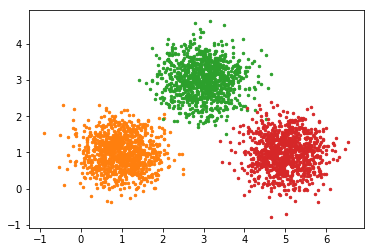

In [136]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X, labels)

### Grupowanie za pomocą KMeans

<b>n_init</b> - Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia


Davies-Bouldin index: 0.173874536381
Dunn index(maxdist): 0.632439459655
Dunn index(pairdist): 15.9166155961
Dunn index(avgdist): 15.9325801052
Silhouette score: 0.678382184303



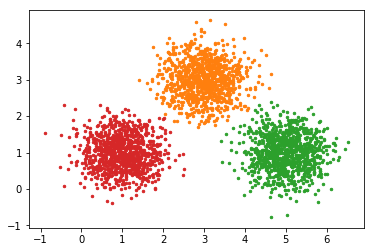

In [137]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=5)
k_means.fit(X)

plotClustering(X, k_means.labels_)

print '''
Davies-Bouldin index: {}
Dunn index(maxdist): {}
Dunn index(pairdist): {}
Dunn index(avgdist): {}
Silhouette score: {}
'''.format(
    davies_bouldin(k_means.cluster_centers_.T, X.T, k_means.labels_),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='maxdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='pairdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='avgdist'),
    silhouette_score(X, k_means.labels_)
)

### Grupowanie za pomocą MiniBatchKMeans


Davies-Bouldin index: 0.173874536381
Dunn index(maxdist): 0.632439459655
Dunn index(pairdist): 15.9166155961
Dunn index(avgdist): 15.9325801052
Silhouette score: 0.678382184303



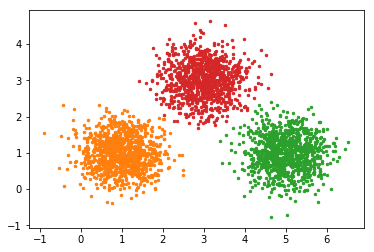

In [138]:
mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=1, max_no_improvement=10, verbose=0, random_state=0)
mini_batch_k_means.fit(X)

plotClustering(X, mini_batch_k_means.labels_)

print '''
Davies-Bouldin index: {}
Dunn index(maxdist): {}
Dunn index(pairdist): {}
Dunn index(avgdist): {}
Silhouette score: {}
'''.format(
    davies_bouldin(k_means.cluster_centers_.T, X.T, k_means.labels_),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='maxdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='pairdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='avgdist'),
    silhouette_score(X, k_means.labels_)
)

### Grupowanie za pomocą Birch bez wtórnego grupowania


Silhouette score: 0.438406232564



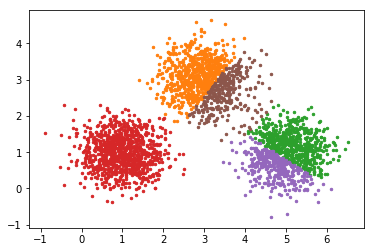

In [147]:
birch = Birch(threshold=0.75, n_clusters=None)
birch.fit(X)

plotClustering(X, birch.labels_)

print '''
Silhouette score: {}
'''.format(
    silhouette_score(X, birch.labels_)
)


Silhouette score: 0.30217093208



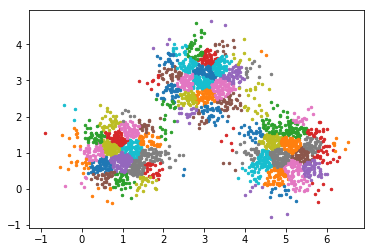

In [146]:
birch = Birch(threshold=0.25, n_clusters=None)
birch.fit(X)

plotClustering(X, birch.labels_)

print '''
Silhouette score: {}
'''.format(
    silhouette_score(X, birch.labels_)
)

### Grupowanie za pomocą Birch z wtórnym grupowaniem


Silhouette score: 0.675223976041



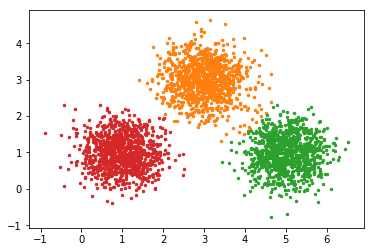

In [158]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

plotClustering(X, birch.labels_)

print '''
Silhouette score: {}
'''.format(
    silhouette_score(X, birch.labels_)
)

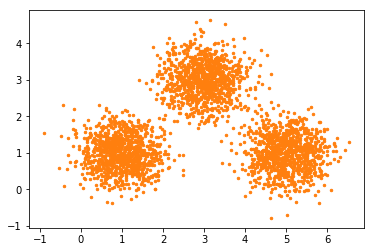

In [157]:
birch = Birch(threshold=15.5, n_clusters=3)
birch.fit(X)

plotClustering(X, birch.labels_)


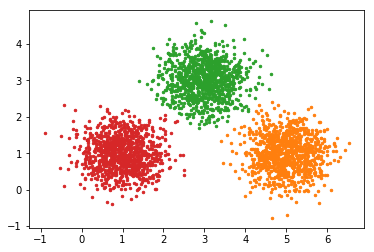

In [159]:
birch = Birch(threshold=0.00000001, n_clusters=3)
birch.fit(X)

plotClustering(X, birch.labels_)

### Grupowanie za pomocą DBScan

<b>eps</b> - The maximum distance between two samples for them to be considered as in the same neighborhood

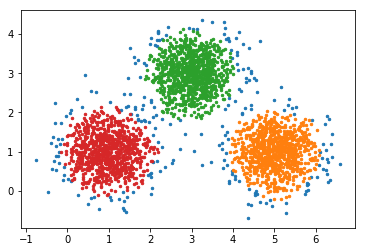

In [8]:
dbscan = DBSCAN(eps=0.25, min_samples=25)
dbscan.fit(X)

plotClustering(X, dbscan.labels_)

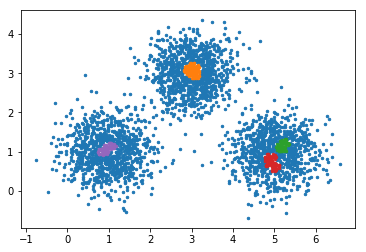

In [9]:
dbscan = DBSCAN(eps=0.1, min_samples=25)
dbscan.fit(X)

plotClustering(X, dbscan.labels_)

In [10]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3])

## 2. Drugi zestaw danych
Dane IRIS

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data


Davies-Bouldin index: 0.373412094635
Dunn index(maxdist): 0.478811193339
Dunn index(pairdist): 4.78248874969
Dunn index(avgdist): 4.90834371678
Silhouette score: 0.550964374642



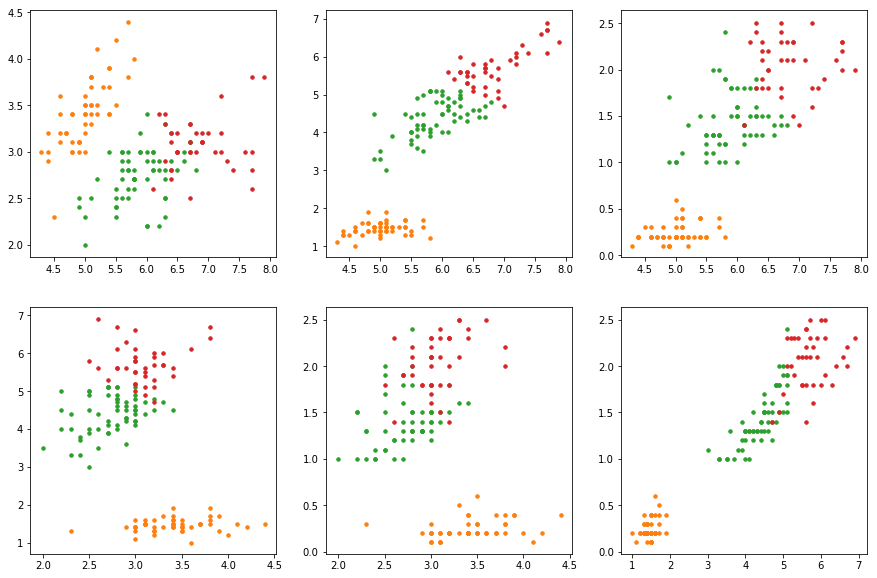

In [12]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))

k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

for i, dim in zip(xrange(2*3), itertools.combinations([0,1,2,3], 2)):
    idx = np.unravel_index(i, (2,3))
    plotClustering(
        X[:,dim],
        k_means.labels_, 
        ax=ax[idx],
        s=12
    )
    
print '''
Davies-Bouldin index: {}
Dunn index(maxdist): {}
Dunn index(pairdist): {}
Dunn index(avgdist): {}
Silhouette score: {}
'''.format(
    davies_bouldin(k_means.cluster_centers_.T, X.T, k_means.labels_),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='maxdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='pairdist'),
    dunn(k_means.cluster_centers_.T, X.T, k_means.labels_, alg='avgdist'),
    silhouette_score(X, k_means.labels_)
)


ValueError: operands could not be broadcast together with shapes (3,3) (5,5) 

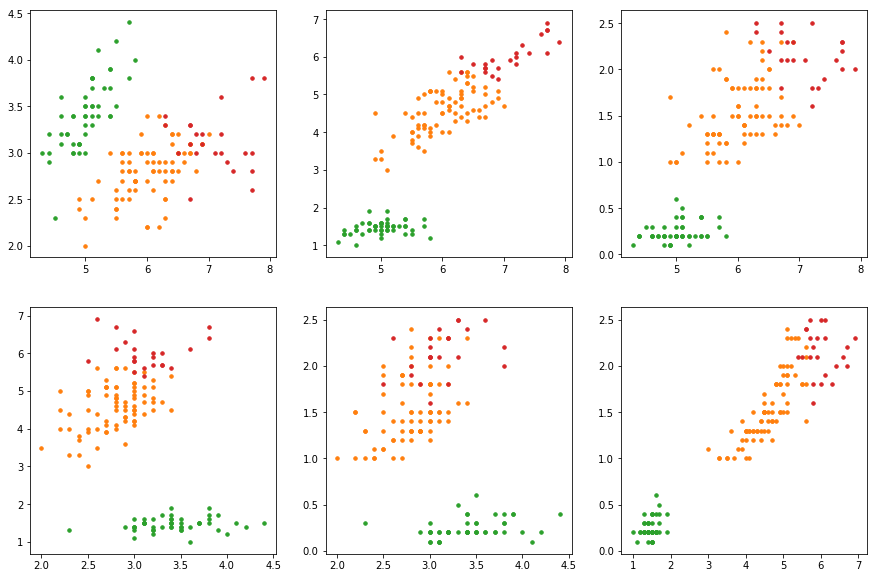

In [13]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))

birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

for i, dim in zip(xrange(2*3), itertools.combinations([0,1,2,3], 2)):
    idx = np.unravel_index(i, (2,3))
    plotClustering(
        X[:,dim],
        birch.labels_, 
        ax=ax[idx],
        s=12
    )

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

for i, dim in zip(xrange(2*3), itertools.combinations([0,1,2,3], 2)):
    idx = np.unravel_index(i, (2,3))
    plotClustering(
        X[:,dim],
        dbscan.labels_, 
        ax=ax[idx],
        s=12
    )

<h1>zad 1</h1>

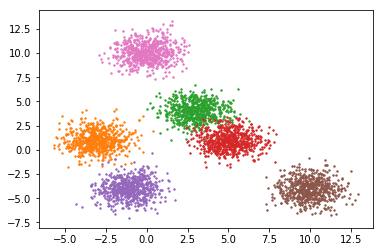

In [102]:
from sklearn import datasets

centers_ = [[-3, 1], [3, 4], [5, 1], [-1, -4], [10, -4], [0, 10]]
X, labels = datasets.make_blobs(n_samples=4000, n_features=2, centers=centers_, cluster_std=1.)

plotClustering(X, labels, s=2)

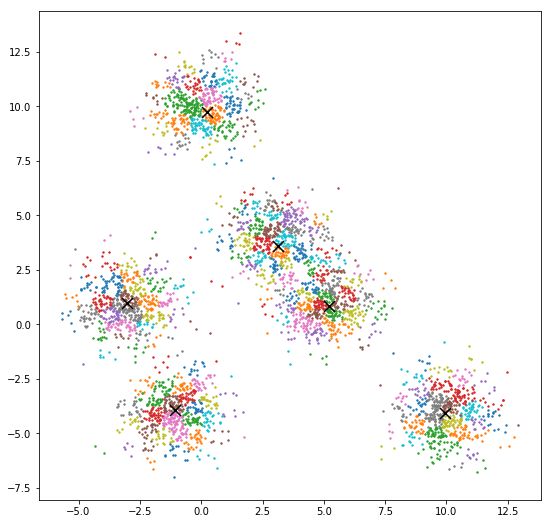

In [127]:
figsize(9,9)
birch = Birch(threshold=0.4, n_clusters=None)
birch.fit(X)
plotClustering(X, birch.labels_, s=2)

scatter(birch.root_.centroids_[:,0], birch.root_.centroids_[:,1], color='black', marker='x', s=120)

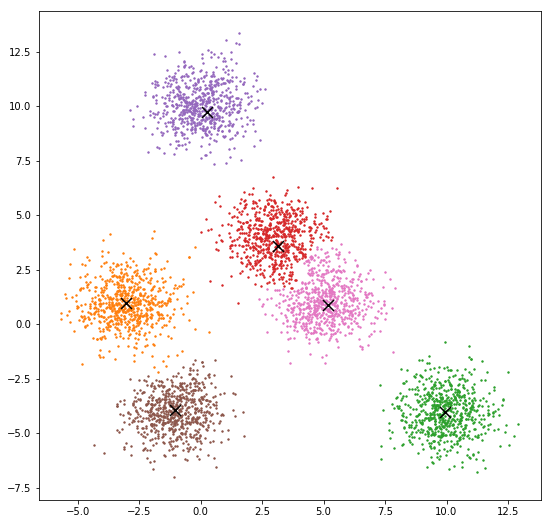

In [129]:
figsize(9,9)
birch = Birch(threshold=0.4, n_clusters=6)
birch.fit(X)
plotClustering(X, birch.labels_, s=2)

scatter(birch.root_.centroids_[:,0], birch.root_.centroids_[:,1], color='black', marker='x', s=120)

<h1>zad 2</h1>

<h3>normalizacja</h3>

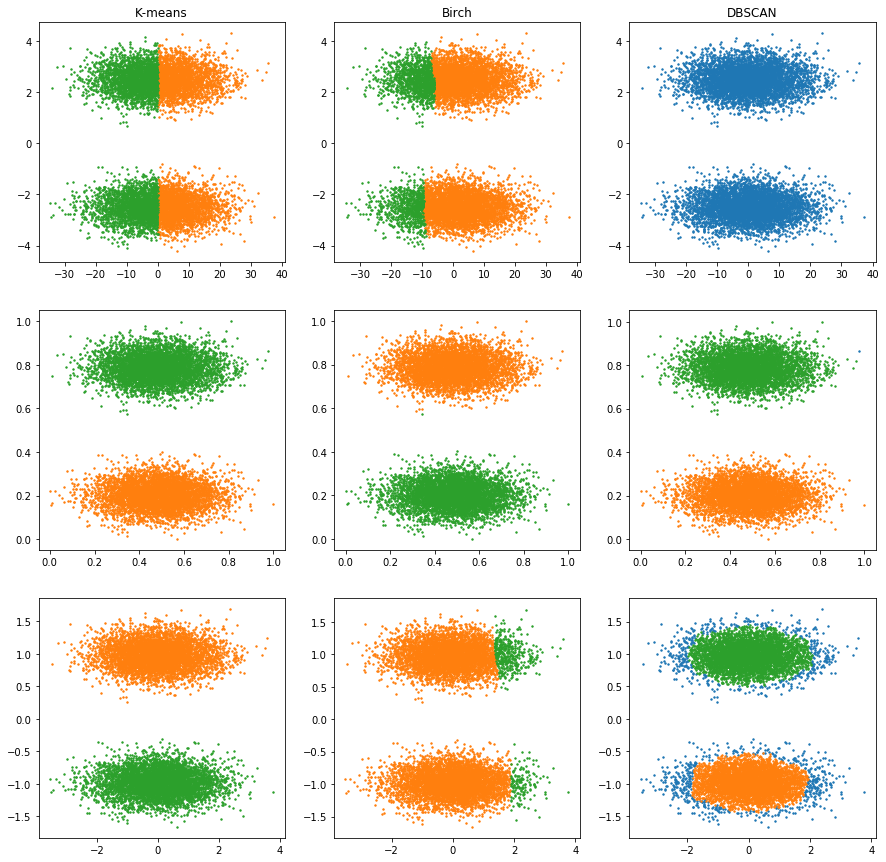

In [36]:
f, ax = subplots(3, 3, figsize=(15,15))

N = 5000
data1 = np.vstack([np.random.randn(N)*10., (np.random.randn(N)-5.)/2.])
data2 = np.vstack([np.random.randn(N)*10., (np.random.randn(N)+5.)/2.])
data = np.hstack([data1, data2])

centers, assig, err = kmeans(data, 2)
plotClustering(data.T, assig, ax=ax[0,0], s=2)
ax[0,0].set_title('K-means')
    
birch = Birch(threshold=0.3, n_clusters=2)
birch.fit(data.T)
plotClustering(data.T, birch.labels_, ax=ax[0,1], s=2)
ax[0,1].set_title('Birch')

dbscan = DBSCAN(eps=.1, min_samples=25)
dbscan.fit(data.T)
plotClustering(data.T, dbscan.labels_, ax=ax[0,2], s=2)
ax[0,2].set_title('DBSCAN')

# normalization
data1 = data.copy()
d1min = data1.min(axis=1)[:, None]
d1max = data1.max(axis=1)[:, None]
data1 = (data1 - d1min) / (d1max - d1min)
data1[0, :] /= data1[0, :].max()
data1[1, :] /= data1[1, :].max()

centers, assig, err = kmeans(data1, 2)
plotClustering(data1.T, assig, ax=ax[1,0], s=2)
    
birch = Birch(threshold=0.3, n_clusters=2)
birch.fit(data1.T)
plotClustering(data1.T, birch.labels_, ax=ax[1,1], s=2)

dbscan = DBSCAN(eps=.1, min_samples=25)
dbscan.fit(data1.T)
plotClustering(data1.T, dbscan.labels_, ax=ax[1,2], s=2)

#standarization
data2 = data.copy()
data2 = (data2 - np.mean(data2, axis=1)[:, None]) / np.std(data2, axis=1)[:, None]

centers, assig, err = kmeans(data2, 2)
plotClustering(data2.T, assig, ax=ax[2,0], s=2)
    
birch = Birch(threshold=0.3, n_clusters=2)
birch.fit(data2.T)
plotClustering(data2.T, birch.labels_, ax=ax[2,1], s=2)

dbscan = DBSCAN(eps=.1, min_samples=25)
dbscan.fit(data2.T)
plotClustering(data2.T, dbscan.labels_, ax=ax[2,2], s=2)

In [23]:
data - np.std(data, axis=1)[:,None]

array([[-21.96761521,   3.07689392, -15.75470905, ..., -19.11103063,
        -14.75050177, -20.96929131],
       [ -9.30653914,  -8.92556842, -11.70532331, ...,  -0.49021514,
         -0.048496  ,   0.65685713]])

In [24]:
np.std(data, axis=1)[:,None]

array([[ 9.92254637],
       [ 5.09720883]])

<h1>zad 3</h1>

In [37]:
from PIL import Image

In [38]:
with open('/pio/scratch/2/ED2015/APEX/APEX_OSD_Package_1.0/APEX_OSD_Package_1.0/APEX_OSD_V1_calibr_cube', 'rb') as f:
    data = np.frombuffer(f.read(), dtype='int16').reshape(285,-1).astype('float32')
    

In [7]:
%%time

k = 10

centers, assig, err = kmeans2(
    data=data, 
    k=k, 
    debug=True, 
    max_iter=6,
    parts=4,
)
assig = assig.astype('int')

Error at iteration 0: 1.34913919549e+14
Error at iteration 1: 8.04514892349e+13
Error at iteration 2: 6.86717203907e+13
Error at iteration 3: 6.51078852936e+13
Error at iteration 4: 6.34280287928e+13
Error at iteration 5: 6.28325078794e+13
CPU times: user 56.9 s, sys: 14.1 s, total: 1min 11s
Wall time: 1min 11s


In [8]:
print '''
Davies-Bouldin index: {}
Dunn index: {}
'''.format(
    davies_bouldin(centers, data, assig),
    dunn(centers, data, assig)
)


Davies-Bouldin index: 9.50709111073e-05
Dunn index: 0.281211942434



In [9]:
cmap = array([
    [181,  34, 166, 0,   2, 193,  61,  255,  70, 224],
    [154, 145,  96, 0,  200, 162, 209,  42,  82,   7],
    [ 96,  52, 125,  255, 211, 170,  45, 24, 211, 232]], dtype=uint8)

In [15]:
cmap = np.random.randint(256, size=(3,k), dtype='uint8')
cmap

array([[ 76, 228,   7, 200, 139, 179, 189, 204,  67,  25],
       [ 59,  56, 153, 197, 131,  55, 213, 217, 119, 241],
       [251, 233,  85, 209,  44, 119,  89, 164, 133, 250]], dtype=uint8)

In [30]:
cmap = array([
    [181,  34, 166,  0,    2,    193,   0,   40,  70,   224],
    [154, 145,  96, 200,  200,   162,   0,   42,   82,    7],
    [ 96,  52, 125,  0,   211,   170,  255,  24,   211,  232]], dtype=uint8)

In [31]:
img = Image.new('RGB', (1500, 1000))
img.putdata(map(tuple, list(cmap[:, assig.astype('int')].T)))

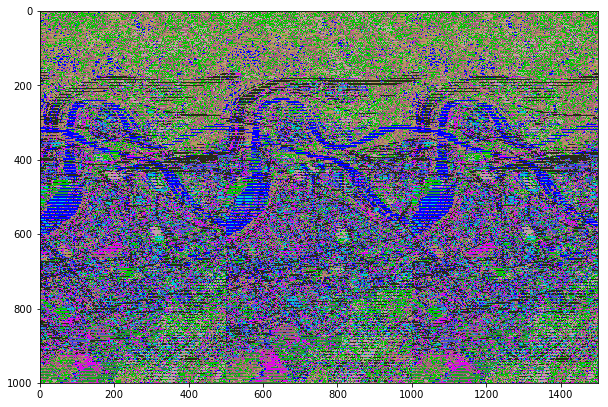

In [32]:
figure(figsize = (10,15))
imshow(img)

In [ ]:
dbscan = DBSCAN(eps=1000., min_samples=25)
dbscan.fit(data.T)
# plotClustering(data1.T, dbscan.labels_, ax=ax[1,2], s=2)